## RQ2 Text Analysis

General plan:
- Follow a similar approach to the Chai-Allah "Data Mining..." paper to create clusters from the data
    - Just use tokenisation first, if 2 big then use lemmatisation
    - for now, just use all words (don't worry about filtering for high frequency words)
    - Use a German version of the word2vec model (see what the baroni one is based on and try to find a German equivalent)
    - use k-means or ward's for the clustering

Open Questions
- How should I handle placenames? See if they form clusters? Filter using gazetteer?
- **HOW DO I CONNECT TO CLASS 3 AND 6 AREAS?** Do I run them separately (but then end up with different clusters for each) or do I run the model on everything to create a classifier and then run that on the two separate corpora? I think the latter makes more sense but I don't really understand how this would work.


Steps:
1. Initial Cleaning
2. Language Handling 
3. Tokenisation
4. Pre-processing (filtering stop words etc, lower-case)
5. Semantic analysis (word2vec)
6. Clustering


In [1]:
# SETUP

# Import packages
import pandas as pd
import numpy as np
import pickle

import spacy 
from langdetect import detect
from langdetect import DetectorFactory
from deep_translator import GoogleTranslator
from collections import Counter
from gensim.models import KeyedVectors  # requires scipy version 1.12 (anything newer doesn't work)


from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from wordcloud import WordCloud


### Step 1: Initial Cleaning

General text preparation to get the data in a format which works for translation and for use with spacy.

Decided not to use the comments as there is no guarantee the comments are an expression of someone's perception about the trail/landscape (they might just be saying the trail looks nice from the original posters description, they might be commenting on the directions, etc)

In [2]:
# STEP 1: LOAD & CLEAN

# Load the master CSV from rq2_step1_data_collection
master = pd.read_csv("./processing/master.csv")

# Add ['None'] to any blank rows
# this is necessary for the next step, but then they will be removed later
master.fillna("['None']", inplace=True)

# Extract the description and captitions and combine them into a single column
raw_text = pd.DataFrame()
raw_text["desc_capt"] = master["description text"] + " " + master["photo_captions"]

# Now remove all the ['None'] text from both columns
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\['None'\]", "", regex=True)

# Remove certain special characters: [, ], ', |, /, \, + 
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\[", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\]", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\'", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\|", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\\", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\/", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\+", "", regex=True)

# This is to address a specific issue in one of the entries
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\n", " ", regex=True)

# Create a list from the column
raw_text_list = raw_text["desc_capt"].astype(str).values.tolist()

# Convert entries which are just a space (" ") to be empty ("")
raw_text_list = [x.strip(' ') for x in raw_text_list]

# Remove all empty entries
raw_text_list = list(filter(None, raw_text_list))

# Check
raw_text_list

['Finndorff-Blockland-St. Jürgen-Ritterhude-Findorff Pause am Wümme Deich, Am Wümme Deich, Weitere Picknick Möglichkeit mit Bank, Foto, Gastronomie mit WC, Gastronomie mit WC, Foto, Weitere Einkehr Möglichkeit mit ECHTErrr, Foto, Kirche St. Jürgen, Möglichkeit für Picknick auf der Wiese!, Eiscafe in Ritterhude, Wümme Brücke, Dammsiel, Seitenwechsel über die Wümme',
 'Flughafenrunde Foto, Foto, Foto, Abzweig zum Park links der Weser , ausgeschildert!!, Abzweig zum Hotel Robben, Foto, Foto, Foto, Ochtumdeich, Fußweg, ein Stück schieben , wunderbarer Weg!, Abzeig zu Picknickplatz, Foto, Foto, Foto, Badestrand, Foto',
 'OHZ, Café, Foto',
 'WSV Hasenbühren - Bremen, Stephaniebrücke über Strom  Huchting Knotenpunkt Abzweig zur Flughafenrunde, Unser Weg heute Richtung Centrum, Endpunkt Stephaniebrücke auf der Neustadtseite',
 'Rund um Bremen Start, Silbersee mit Bade-  Picknick Möglichkeit und WC, Wassermühle Barrien , Picknick Platz',
 'Radtour Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto,

### Step 2: Language Handling: Translate to German

As the vast majority of text is in German, I will use this as the base language. I have the option now to either remove anything not in German or to translate it. Although translation is not ideal (maybe some of original meaning is lost/altered), I think this is a better option than just removing the other languages entirely. So here I will tranlsate everything into German. 

As there were some issues with this at first, Ross suggested only translating when there are enough words, for example at least 3 unique tokens. Any language detection algorithm will struggle more when there are only 1 or 2 unique words to go on. This requires some preliminary tokenisation to get the count of unique tokens. **I then discard the text for a trail if it has less than 3 unique tokens (most of these are places where people have used the "Foto" placeholder)**


langdetect package: https://anaconda.org/conda-forge/langdetect 
- Use to check if already German

deep-translator package: https://pypi.org/project/deep-translator/
- Using Google Translate as it doesn't require API key (DeepL requires API key)


count_dict = dict(zip(raw_text_list, unique_token_counts))

In [3]:
# STEP 2: FILTER OUT SHORT TEXTS

# Load the spacy model
nlp = spacy.load("de_core_news_sm")

# Create an empty list to store the unique token counts for each trail
unique_token_counts = []

# Tokenise the text for each trail & count the number of unique tokens for each trail
for trail_text in raw_text_list:
    doc = nlp(trail_text)
    tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
    unique_tokens = set(tokens)
    unique_token_counts.append(len(unique_tokens))

# Combine results into a df
raw_text_counts = pd.DataFrame()
raw_text_counts["text"] = raw_text_list
raw_text_counts["unique_tokens"] = unique_token_counts

# Filter df to only include rows where unique_tokens >= 3
raw_text_counts = raw_text_counts.loc[(raw_text_counts["unique_tokens"] >= 3)]

# Save the text column as a list for use in the next steps
raw_text_3token_list = raw_text_counts["text"].astype(str).values.tolist()

# Check
raw_text_3token_list


['Finndorff-Blockland-St. Jürgen-Ritterhude-Findorff Pause am Wümme Deich, Am Wümme Deich, Weitere Picknick Möglichkeit mit Bank, Foto, Gastronomie mit WC, Gastronomie mit WC, Foto, Weitere Einkehr Möglichkeit mit ECHTErrr, Foto, Kirche St. Jürgen, Möglichkeit für Picknick auf der Wiese!, Eiscafe in Ritterhude, Wümme Brücke, Dammsiel, Seitenwechsel über die Wümme',
 'Flughafenrunde Foto, Foto, Foto, Abzweig zum Park links der Weser , ausgeschildert!!, Abzweig zum Hotel Robben, Foto, Foto, Foto, Ochtumdeich, Fußweg, ein Stück schieben , wunderbarer Weg!, Abzeig zu Picknickplatz, Foto, Foto, Foto, Badestrand, Foto',
 'OHZ, Café, Foto',
 'WSV Hasenbühren - Bremen, Stephaniebrücke über Strom  Huchting Knotenpunkt Abzweig zur Flughafenrunde, Unser Weg heute Richtung Centrum, Endpunkt Stephaniebrücke auf der Neustadtseite',
 'Rund um Bremen Start, Silbersee mit Bade-  Picknick Möglichkeit und WC, Wassermühle Barrien , Picknick Platz',
 'Radtour Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto,

In [19]:
# STEP 2: TRANSLATE TO GERMAN (RUN ONCE!)

# Create list for all translated text
raw_text_de = []

# Initiate some counts to see how much text is translated
de_detected = 0
translations_performed = 0
  
# Set seed for langdetect for reproducible results
DetectorFactory.seed = 487

# Check language, translate as needed and append to list 
for trail_text in raw_text_3token_list:
    # Check language
    input_lang = detect(trail_text) 
    # If already German, append to German list
    if input_lang == "de":
        raw_text_de.append(trail_text)
        de_detected = de_detected + 1
    # If not German, translate and append to German list    
    else:
        # Translate using Google Translate
        translated_chunk = GoogleTranslator(source=input_lang, target='de').translate(text=trail_text)
        raw_text_de.append(translated_chunk)
        translations_performed = translations_performed + 1

# Check proportions
print("Number of trails in German:", de_detected)
print("Number of translated trails:", translations_performed)
print("Percentage of translated trails:", round(((translations_performed / (translations_performed + de_detected))*100),2))

Number of trails in German: 198
Number of translated trails: 94
Percentage of translated trails: 32.19


In [ ]:
# STEP 2: ALTERNATIVE TRANSLATION APPROACH

raw_text_de_test = []
translated_count = 0
skipped_count = 0

for trail_text in raw_text_3token_list:
    translated = GoogleTranslator(source='auto', target='de').translate(text=trail_text)

    # Check if translation changed anything
    if translated.strip() == trail_text.strip():
        skipped_count += 1
    else:
        translated_count += 1

    raw_text_de_test.append(translated)

print(f"Translated: {translated_count}")
print(f"Skipped (already German or unchanged): {skipped_count}")




Translated: 82
Skipped (already German or unchanged): 210


In [6]:
raw_text_de_test

['Finndorff-Blockland-St. Jürgen-Ritterhude-Findorff Pause am Wümme Deich, Am Wümme Deich, Weitere Picknick Möglichkeit mit Bank, Foto, Gastronomie mit WC, Gastronomie mit WC, Foto, Weitere Einkehr Möglichkeit mit ECHTErrr, Foto, Kirche St. Jürgen, Möglichkeit für Picknick auf der Wiese!, Eiscafe in Ritterhude, Wümme Brücke, Dammsiel, Seitenwechsel über die Wümme',
 'Flughafenrunde Foto, Foto, Foto, Abzweig zum Park links der Weser , ausgeschildert!!, Abzweig zum Hotel Robben, Foto, Foto, Foto, Ochtumdeich, Fußweg, ein Stück schieben , wunderbarer Weg!, Abzeig zu Picknickplatz, Foto, Foto, Foto, Badestrand, Foto',
 'Ohz, Cafe, Foto',
 'WSV Hasenbühren - Bremen, Stephaniebrücke über Strom  Huchting Knotenpunkt Abzweig zur Flughafenrunde, Unser Weg heute Richtung Centrum, Endpunkt Stephaniebrücke auf der Neustadtseite',
 'Rund um Bremen Start, Silbersee mit Bade-  Picknick Möglichkeit und WC, Wassermühle Barrien , Picknick Platz',
 'Radtour Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto,

In [20]:
# STEP 2: SAVE TRANSLATED TEXT

pickle.dump(raw_text_de, open("./processing/raw_text_de.p", "wb"))

In [21]:
# STEP 2: LOAD TRANSLATED TEXT

raw_text_de = pickle.load(open("./processing/raw_text_de.p", "rb"))

### Step 3: Tokenisation

German spacy model options: https://spacy.io/models/de 

de_core_news_sm (I've installed this one so far)
de_core_news_md
de_core_news_lg
de_dep_news_trf

Which is best to use?

**REVISIT THIS LATER**


In [22]:
# STEP 3: TOKENISATION

# Load the spacy model
nlp = spacy.load("de_core_news_sm")

# Create an empty list to store the tokens
doc = []

# Tokenise the raw_text input
for string in raw_text_de:
    doc.extend(nlp(string))

# Print the tokens to check
#for token in doc:
#    print(token)


### Step 4: Pre-processing 

Remove stop words, punctuation & numbers from the token list. 

Convert all to lower-case.

**Also:** 
- remove the word "Foto" as this is just placeholder text
- "null" is also used as a placeholder sometimes so I have included this as a stop word as well

In [23]:
# STEP 4: STOP WORDS ETC

# Add words to stop list
nlp.vocab["Foto"].is_stop = True
nlp.vocab["foto"].is_stop = True
nlp.vocab["Fotos"].is_stop = True
nlp.vocab["Photo"].is_stop = True
nlp.vocab["null"].is_stop = True

# Filter out tokens that are stop words (is_stop), puncutation (is_punct), 
# numbers (is_digit & like_num) OR spaces (is_space)
filtered_tokens = [token.text for token in doc if not token.is_stop | token.is_punct | 
                   token.is_digit | token.like_num | token.is_space]

# Empty list for lower-case versions
filtered_tokens_lc = []

# Convert to lower-case 
for token in filtered_tokens:
    token_lc = token.lower()
    filtered_tokens_lc.append(token_lc)

# Check
print(filtered_tokens_lc)

['finndorff-blockland-st', 'jürgen-ritterhude-findorff', 'pause', 'wümme', 'deich', 'wümme', 'deich', 'picknick', 'möglichkeit', 'bank', 'gastronomie', 'wc', 'gastronomie', 'wc', 'einkehr', 'möglichkeit', 'echterrr', 'kirche', 'st.', 'jürgen', 'möglichkeit', 'picknick', 'wiese', 'eiscafe', 'ritterhude', 'wümme', 'brücke', 'dammsiel', 'seitenwechsel', 'wümme', 'flughafenrunde', 'abzweig', 'park', 'links', 'weser', 'ausgeschildert', 'abzweig', 'hotel', 'robben', 'ochtumdeich', 'fußweg', 'stück', 'schieben', 'wunderbarer', 'weg', 'abzeig', 'picknickplatz', 'badestrand', 'ohz', 'kaffee', 'wsv', 'hasenbühren', 'bremen', 'stephaniebrücke', 'strom', 'huchting', 'knotenpunkt', 'abzweig', 'flughafenrunde', 'weg', 'richtung', 'centrum', 'endpunkt', 'stephaniebrücke', 'neustadtseite', 'bremen', 'start', 'silbersee', 'bade-', 'picknick', 'möglichkeit', 'wc', 'wassermühle', 'barrien', 'picknick', 'platz', 'radtour', 'high', '-luege', 'clausthal', 'zellerfeld', 'nah', 'lautenthal', 'hauptschacht', '

In [24]:
# STEP 4: CHECKING SOME RESULTS? :) 

word_freq = Counter(filtered_tokens_lc)

common_words = word_freq.most_common(20)

common_words


[('hwn', 79),
 ('braunschweig', 65),
 ('weg', 30),
 ('harzer', 28),
 ('links', 27),
 ('photos', 27),
 ('rechts', 24),
 ('parkplatz', 21),
 ('wandernadel', 21),
 ('sachsenhagen', 21),
 ('start', 19),
 ('nummer', 19),
 ('schöne', 18),
 ('brocken', 18),
 ('st.', 17),
 ('wald', 17),
 ('export', 16),
 ('bad', 15),
 ('km', 15),
 ('tour', 13)]

I think HWN stands for Harzer Wandernadel: a hiking badge system for the Harz mountains https://en.wikipedia.org/wiki/Harzer_Wandernadel

### STEP 5: Semantic analysis (word2vec)

Using the de_wiki word2vec model from https://sites.google.com/site/fritzgntr/software-resources/semantic_spaces because it is the closest one to the baroni model used in the Chai-allah paper but for German. 

The semantic spaces are provided in .rda format for R but can be export as a txt for use outside R using the following commands (in R). NOTE: I had to adjust from the instruction on the source website as it didn't account for use in gensim, which then meant I had problems with quotes and separators.

 load("C:/Users/ninam/Documents/UZH/04_Thesis/code/nm_forest_thesis/word2vec/de_wiki.rda")

 write.table(de_wiki, file = "C:/Users/ninam/Documents/UZH/04_Thesis/code/nm_forest_thesis/word2vec/de_wiki.txt", row.names = TRUE, col.names = FALSE, quote = FALSE, sep = " ")
 

 Some useful notes/resources:
 - "a word embedding refers to a vector representation of a particular word or phrase in a multidimensional space" (Generally this website is helpful: https://okan.cloud/posts/2022-05-02-text-vectorization-using-python-word2vec/)
 - https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381
 - https://medium.com/@denis.arvizu/text-clustering-using-word2vec-a89fbd9b9d0f

In [ ]:
# STEP 5: MODEL PREP (RUN ONCE!)

# First I need to adjust the encoding and add the header information required by gensim
# Then I can save it in gensim format for easier use

# Count rows and vector size for header info
with open("./word2vec/de_wiki.txt", encoding="ISO-8859-1") as f:
    lines = f.readlines()

num_words = len(lines)
vector_size = len(lines[0].split()) - 1

# Write in utf-8 with header info
with open("./word2vec/de_wiki_utf8_header.txt", "w", encoding="utf-8") as f:
    f.write(f"{num_words} {vector_size}\n")
    f.writelines(lines)

# Load model (from new txt file) with gensim
model = KeyedVectors.load_word2vec_format("./word2vec/de_wiki_utf8_header.txt", binary=False)

# Save the model in optimised gensim format (this will make the loading faster for next time)
model.save("./word2vec/de_wiki_final.model")

In [25]:
# STEP 5: CHECKING MODEL

# Load model from model file
model = KeyedVectors.load('./word2vec/de_wiki_final.model')

# Which tokens are known versus which are missing in model?
known_tokens = [token for token in filtered_tokens_lc if token in model]
unique_known_tokens = set(known_tokens)
unique_known_count = len(unique_known_tokens)

missing_tokens = [token for token in filtered_tokens_lc if token not in model]
unique_missing_tokens = set(missing_tokens)
unique_missing_count = len(unique_missing_tokens)

# Print results
print("Total known tokens", len(known_tokens))
print("Total missing tokens", len(missing_tokens))
print("Percentage absolute missing:", round((len(missing_tokens)/(len(known_tokens)+len(missing_tokens)) *100), 2))
print("-----")
print("Unique known tokens:", unique_known_count)
print("Unique missing tokens:", unique_missing_count)
print("Percentage unique missing:", round((unique_missing_count/(unique_known_count+unique_missing_count)*100), 2))
print("-----")
print("Missing tokens:", unique_missing_tokens)



Total known tokens 3022
Total missing tokens 986
Percentage absolute missing: 24.6
-----
Unique known tokens: 1586
Unique missing tokens: 659
Percentage unique missing: 29.35
-----
Missing tokens: {'volkensen', 'zicht', 'drilandsee', 'amdreaaberg', 'silberteich', 'esperke', 'ahlsburg', 'markatal', 'hirschallee', 'pfeil-denkmal', 'nienwalde', 'wendefurther', '-tests', 'bäumlersklippe', 'schnetzchen', 'weensen', 'schnacher', 'bodensteiner', 's.', 'ithkammweg', 'christianental', 'dicker-stein-und-dickes-eis', 'horeburg', 'moltkewarte', 'rundour', 'münchhausen-museum', 'vomittags-runde', 'café', 'wegweiser1', 'königsruhe', 'eckersprung', 'paternosterklippen', 'wiechendorf', 'brockenstrasse', 'destedt', 'klapprädern', 'prinz-albrecht-denkmal', '-miuleman', 'beuningerstraat', '-verbrennungsmittel', 'lutherbuche', 'oltermann', 'gefietst', 'krockstein', 'harlyberg', 'pietzmor', 'nonnenstein', 'winterspaziergang', 'echem', 'hasenbühren', '5e', 'routebeschrijving', 'hexentanzplatz-bode-teufelsbr

In [26]:
# STEP 5: CONVERT TOKENS TO VECTORS (CREATE WORD EMBEDDINGS)

# Load model from model file
model = KeyedVectors.load('./word2vec/de_wiki_final.model')

# Create empty list to store vectors
vectors = []

# Create empty list to store valid tokens (i.e. tokens which are present in the model)
valid_tokens = []

# Store the vectors for each token
for token in filtered_tokens_lc:
    if token in model:
        vector = model[token]
        vectors.append(vector)
        valid_tokens.append(token)


**NOTE**
I thought I had to change the code above so that the tokens were grouped together by their trail (so when determining the vector it takes the context of the words in the correct trail description) - BUT I think this is actually not the way the model works: the model uses a context window of 5 when training the model to create the vectors - but once the vectors are created they are just applied on a word-by-word basis (i.e. bag of words model). The code above basically works the same as the code in this chunk - either is okay.

In [27]:
# STEP 5: COSINE SIMILARITY/DISIMILARITY

# Approximate cosine similarity (for kmeans)
normalised_vectors = normalize(vectors)


### Step 6: Clustering

I'll try it out with k-means first.

First step is to see how many clusters I should make using the elbow method.

Note I got the following error message when running this originally: *UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.* To resolve this I edited the **system environment variables** using the instructions in the first answer here: https://stackoverflow.com/questions/69596239/how-to-avoid-memory-leak-when-dealing-with-kmeans-for-example-in-this-code-i-am

Resources
- GEO881 Assignment 1, Part 2 (kmeans classification - but in R)
- https://www.w3schools.com/python/python_ml_k-means.asp
- https://medium.com/@m3redithw/wordclouds-with-python-c287887acc8b


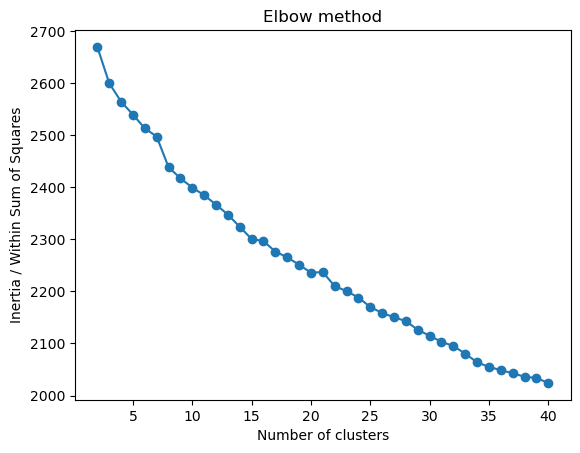

In [28]:
# STEP 6: DETERMINE NUMBER OF CLUSTERS

# Set seed for reproducible results
#np.random.seed(244)

# Create empty list to intertias (within cluster sum of squares)
inertias = []

# Test kmeans intertias/within ss for 2-40 clusters
# Random state needed for reproducible results
for k in range(2,41):
  kmeans = KMeans(n_clusters=k, max_iter=200, random_state=384)
  kmeans.fit(normalised_vectors)
  inertias.append(kmeans.inertia_)

# Generate the elbow plot
plt.plot(range(2,41), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia / Within Sum of Squares')
plt.show() 

Based on plot above - 14 clusters?

In [29]:
# STEP 6: KMEANS WITH 14 CLUSTERS

# Set seed for reproducible results
np.random.seed(11)

# Define number of clusters basedon elbow plot
n_clusters = 14

# Generate kmeans clusters and labels
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(normalised_vectors)
labels = kmeans.labels_

# Create a df with the cluster number for each token contained in the model
token_cluster_all = pd.DataFrame({"token": valid_tokens, "cluster": labels})

# Check
token_cluster_all


,token,cluster
0,pause,10
1,wümme,1
2,deich,1
3,wümme,1
4,deich,1
...,...,...
3017,südharz,8
3018,karstwanderweg,1
3019,stempelstelle,1
3020,queste,13


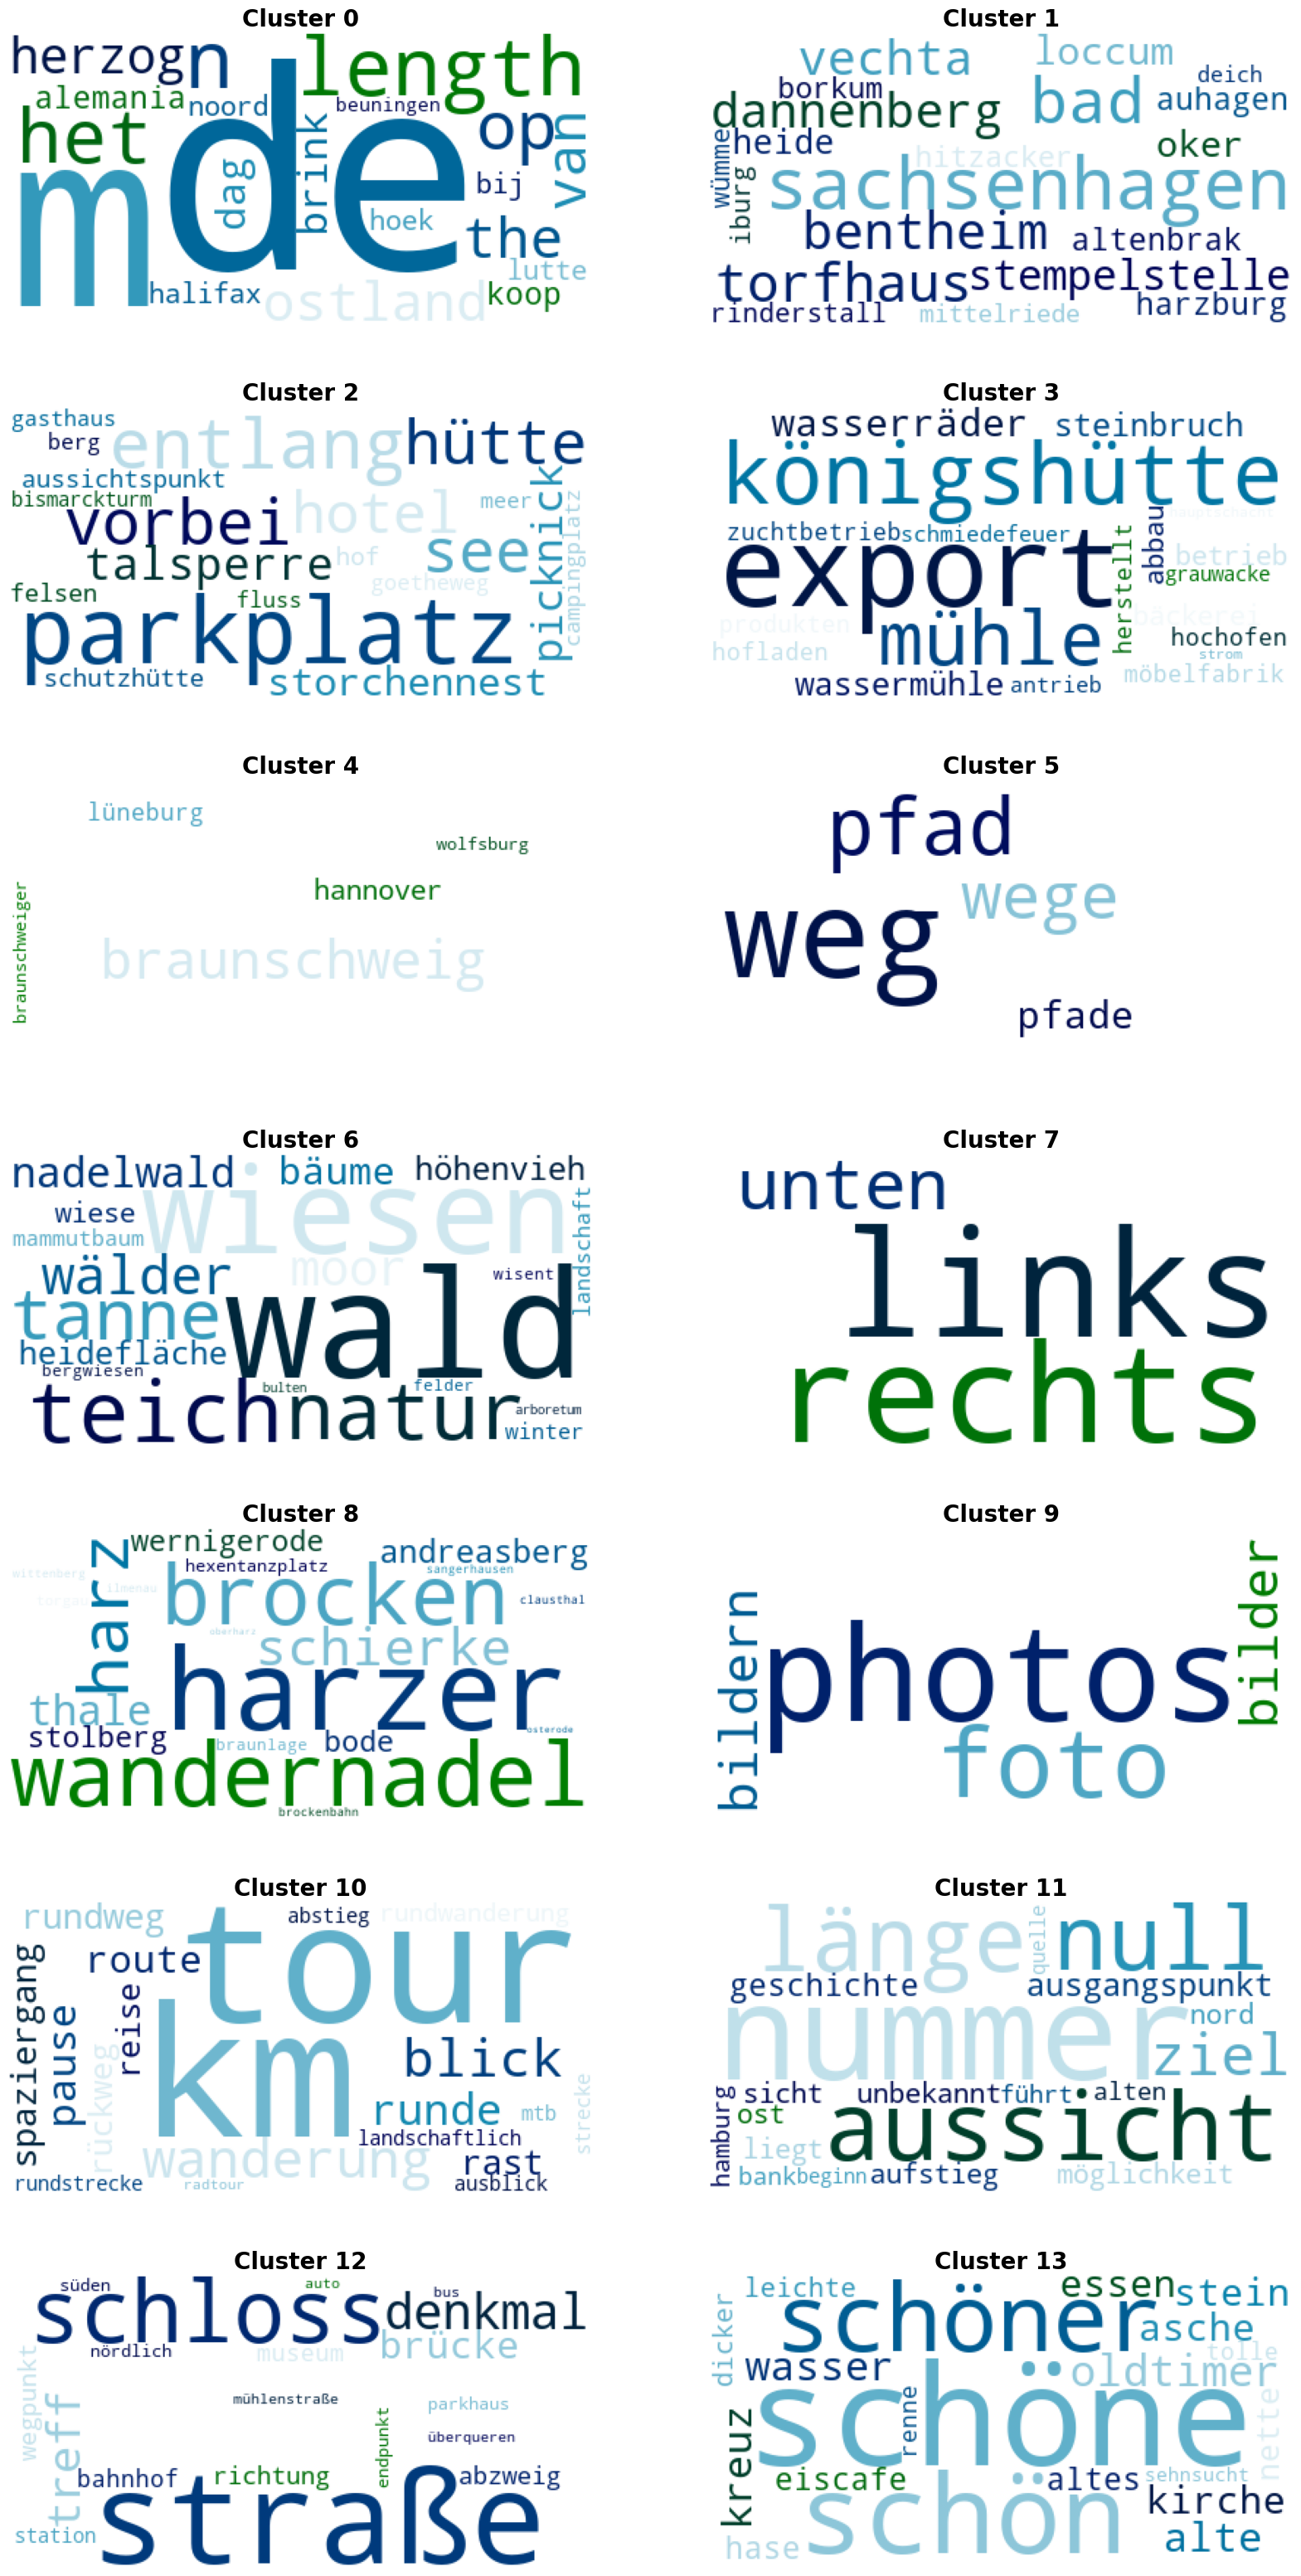

In [30]:
# STEP 6: EXPLORE CLUSTER WORD CLOUDS

# Create a function to count the token frequencies for each cluster 
def get_cluster_freq(df, clus_num):
    token_list = df.loc[df["cluster"] == clus_num, "token"]
    delimiter = " " 
    join_str = delimiter.join(token_list)
    freqs = Counter(join_str.split())
    return freqs

# Create empty lists for storing the word cloud plots 
all_wc = []

# For each cluster number (0-13) use the get_cluster_freq function to get token frequencies,
# input those frequencies into the WordCloud generator and append each wc to list
# IMPORTANT: I HAVE LIMITED TO SHOW TOP 20 TOKENS IN EACH CLUSTER
for clus_num in range(14):  
    freqs = get_cluster_freq(token_cluster_all, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='ocean', 
                   max_words=20).generate_from_frequencies(freqs)
    all_wc.append(wc)

# Create custom titles
all_titles = ["Cluster 0", "Cluster 1", 
              "Cluster 2",  "Cluster 3", 
              "Cluster 4", "Cluster 5", 
              "Cluster 6", "Cluster 7", 
              "Cluster 8", "Cluster 9",
              "Cluster 10", "Cluster 11",
              "Cluster 12", "Cluster 13"]

old_titles = ["Cluster 0 - Distances/Units", "Cluster 1 - Religion? (spiritual CES?)", 
              "Cluster 2 - Odd mix...",  "Cluster 3 - Nature Words", 
              "Cluster 4 - Placenames", "Cluster 5 - Harz placenames", 
              "Cluster 6 - Trail/Route Words", "Cluster 7 - Placemames", 
              "Cluster 8 - Old things (heritage CES?)", "Cluster 9 - Trail/Route Words",
              "Cluster 10 - Directions/Transportation", "Cluster 11 - Directions"]


# Create a figure with 14 subplots
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 40))
axes = axes.flatten()

# Iterate through word clouds and titles to plot
for i, (wc, title) in enumerate(zip(all_wc, all_titles)):
    axes[i].imshow(wc)
    axes[i].axis('off')
    axes[i].set_title(title, fontsize=20, fontweight="bold")

# Display final figure
plt.show()


